# issue 1 - load ACCESS-ESM1.5 data

#### Date: 11 October, 2024

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

# Install ACDtools locally

In [1]:
# this needs to be set via a custom edit per user at the moment
!pip install --user -e /g/data/es60/users/thomas_moore/code/ACDtools

Obtaining file:///g/data/es60/users/thomas_moore/code/ACDtools
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ACDtools (pyproject.toml) ... done
  Created wheel for ACDtools: filename=ACDtools-0.1-0.editable-py3-none-any.whl size=3511 sha256=810f3be15a2c39f59598d36e87ebdc900b42b15a7d064d872e0be3adbeea824c
  Stored in directory: /jobfs/129888630.gadi-pbs/pip-ephem-wheel-cache-tgnj7zoy/wheels/b6/a3/f2/6ce45fbdc116ad50e421d6a11cb060cc796e867501807af446
Successfully built ACDtools
  Attempting uninstall: ACDtools
    Found existing installation: ACDtools 0.1
    Uninstalling ACDtools-0.1:
      Successfully uninstalled ACDtools-0.1


In [21]:
# Enable autoreload in the notebook
%load_ext autoreload
%autoreload 1 
%aimport ACDtools.util
%aimport ACDtools.ard
# Importing from your local package util.py
from ACDtools.util import test_function
from ACDtools.util import detect_compute_platform
from ACDtools.util import load_config
from ACDtools.util import start_dask_cluster_from_config
from ACDtools.util import report_esm_unique
from ACDtools.util import var_name_info
from ACDtools.util import list_catalog_query_kwargs
from ACDtools.util import load_cmip6_fs38_datastore
from ACDtools.util import show_methods
from ACDtools.util import load_cmip6_CLEX_datastore
# ard.py
from ACDtools.ard import load_ACCESS_ESM_ensemble
from ACDtools.ard import load_ACCESS_ESM
from ACDtools.ard import find_chunking_info

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notebook settings

### filter warnings

In [3]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings

# Dask cluster from config
`client, cluster = start_dask_cluster_from_config('netcdf_work')`
<br>OR<br>
`client, cluster = start_dask_cluster_from_config('zarr_work')`

In [4]:
client, cluster = start_dask_cluster_from_config('netcdf_work')

Cluster started with 28 workers.
Dashboard available at: /proxy/8787/status


# Issue: write function to load ACCESS-ESM1.5 data object using intake catalogs at NCI
- https://github.com/Thomas-Moore-Creative/ACDtools/issues/1

## utilise CMIP6 data catalogs for NCI holdings

##### Information on climate data catalogs across Australian HPC

**ACCESS-NRI** https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/how.html <br>
**NCI** https://opus.nci.org.au/pages/viewpage.action?pageId=213713098


##### $\bigstar$ Get inspiration from ACCESS-NRI intake catalog docs: ACCESS-ESM1-5 CMIP6 example
https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html

## import packages

In [5]:
import intake
import xarray as xr
import numpy as np
import gc
import json

### import the ACCESS-NRI catalog

In [ ]:
catalog = intake.cat.access_nri

### (1) "I know I want Australian CMIP6 data - so that's fs38 and I need access to that NCI project"

In [ ]:
cmip6_fs38_datastore = catalog.search(name='cmip6_fs38').to_source()

### (2) "what are the realms covered by cmip6_fs38?"

In [ ]:
report_esm_unique(cmip6_fs38_datastore,keep_list=['realm'])

### (3) I want to see what variables, over what frequencies, are available in both the 'ocean' & 'oceanBgchem' realms

In [ ]:
cmip6_fs38_ocean_datastore = cmip6_fs38_datastore.search(realm=['ocean','ocnBgchem'])

In [ ]:
[sorted_unique_dict, table_data] = report_esm_unique(cmip6_fs38_ocean_datastore,return_results=True)

## what is the long name of a particular variable?

In [ ]:
var_name_info(cmip6_fs38_ocean_datastore,'intpp')

## filter catalog for final ACCESS-ESM1.5 dataset

In [ ]:
final_search = cmip6_fs38_ocean_datastore.search(file_type='l',
                    variable_id='intpp',source_id='ACCESS-ESM1-5',experiment_id='historical')

In [ ]:
report_esm_unique(final_search)

## what is the chunking of the files in this final_search catalog?

In [ ]:
final_search.df['path'].iloc[0]

In [ ]:
find_chunking_info(final_search,'intpp',return_results=False)

## load without specifying any chunking

In [ ]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(final_search)

In [ ]:
ds_ESM15_esorted

#### One still needs to know what dimensions (1, 300, 360 ; ) refers to and something about MB size per chunk to set the time to 220 . . . these rules of thumb should be in the yaml settings file until much more complicated heuristics could be coded

In [ ]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(final_search,chunking_settings={'chunks':{'member':1,'time':220,'j':300,'i':360}})

In [ ]:
ds_ESM15_esorted

In [ ]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(final_search,chunking_key='ACCESS_ESM15_2D')

In [ ]:
ds_ESM15_esorted

In [ ]:
ds_ESM15_esorted.isel(member=0).mean('time').intpp.plot()

## 3D dataset?

In [ ]:
thetao_search = cmip6_fs38_ocean_datastore.search(file_type='l',
                    variable_id='thetao',source_id='ACCESS-ESM1-5',experiment_id='historical')

In [ ]:
report_esm_unique(thetao_search)

In [ ]:
find_chunking_info(thetao_search,'thetao',return_results=False)

In [ ]:
find_chunking_info(thetao_search,'thetao',return_results=True)

In [ ]:
xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r3i1p1f1/Omon/thetao/gn/v20191203/thetao_Omon_ACCESS-ESM1-5_historical_r3i1p1f1_gn_189001-189912.nc')

In [ ]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(thetao_search)

In [ ]:
ds_ESM15_esorted

In [ ]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(thetao_search,chunking_key='ACCESS_ESM15_3D')

In [ ]:
ds_ESM15_esorted

# let's use the tools as they exist to try to start the workflow

## I want Australian CMIP6 data

In [ ]:
cmip6_fs38_datastore = load_cmip6_fs38_datastore()

In [ ]:
report_esm_unique(cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']))

In [ ]:
CSEPTA_intpp_catalog = cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA'])

In [ ]:
CSEPTA_intpp_catalog

In [ ]:
show_methods(CSEPTA_intpp_catalog)

In [ ]:
report_esm_unique(CSEPTA_intpp_catalog)

In [ ]:
CSEPTA_intpp_catalog.unique()['path']

In [ ]:
search_dict = dict(experiment_id = 'historical',source_id = 'ACCESS-ESM1-5',variable_id = ['intpp'],realm = ['ocnBgchem'], frequency = 'mon',file_type='f')

In [ ]:
search = cmip6_fs38_datastore.search(**search_dict)
search

In [ ]:
search.unique()['path']

# let's repeat workflow with CLEX catalog

In [6]:
cmip6_fs38_datastore = load_cmip6_CLEX_datastore()

In [7]:
load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']['CLEX_catalog']

{'experiment_id': ['ssp126'],
 'source_id': 'ACCESS-ESM1-5',
 'variable_id': ['thetao'],
 'table_id': 'Omon'}

In [8]:
report_esm_unique(cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']['CLEX_catalog']))

╒════════════════╤═════════════════╕
│ Category       │ Unique values   │
╞════════════════╪═════════════════╡
│ activity_id    │ ScenarioMIP     │
├────────────────┼─────────────────┤
│ date_range     │ 201501-202412   │
│                │ 202501-203412   │
│                │ 203501-204412   │
│                │ 204501-205412   │
│                │ 205501-206412   │
│                │ 206501-207412   │
│                │ 207501-208412   │
│                │ 208501-209412   │
│                │ 209501-210012   │
│                │ 210101-211012   │
│                │ 211101-212012   │
│                │ 212101-213012   │
│                │ 213101-214012   │
│                │ 214101-215012   │
│                │ 215101-216012   │
│                │ 216101-217012   │
│                │ 217101-218012   │
│                │ 218101-219012   │
│                │ 219101-220012   │
│                │ 220101-221012   │
│                │ 221101-222012   │
│                │ 222101-223012   │
│

In [9]:
find_chunking_info(cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']['CLEX_catalog']),'thetao',return_results=True)

╒══════════════════════════╤═════════════════════════════════════════════════════════════════╕
│ Variable                 │ thetao                                                          │
├──────────────────────────┼─────────────────────────────────────────────────────────────────┤
│ Chunk sizes (first file) │ 1, 25, 150, 180 ;                                               │
├──────────────────────────┼─────────────────────────────────────────────────────────────────┤
│ File path (first file)   │ /g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/              │
│                          │ ACCESS-ESM1-5/ssp126/r10i1p1f1/Omon/thetao/gn/                  │
│                          │ v20210318/                                                      │
│                          │ thetao_Omon_ACCESS-ESM1-5_ssp126_r10i1p1f1_gn_201501-202412.nc/ │
├──────────────────────────┼─────────────────────────────────────────────────────────────────┤
│ Chunk sizes (last file)  │ 1, 25, 150, 180 ;    

{'thetao': {'chunk_sizes_first': '1, 25, 150, 180 ;',
  'file_path_first': '/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp126/r10i1p1f1/Omon/thetao/gn/v20210318/thetao_Omon_ACCESS-ESM1-5_ssp126_r10i1p1f1_gn_201501-202412.nc',
  'chunk_sizes_last': '1, 25, 150, 180 ;',
  'file_path_last': '/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp126/r9i1p1f1/Omon/thetao/gn/v20210318/thetao_Omon_ACCESS-ESM1-5_ssp126_r9i1p1f1_gn_229101-230012.nc'}}

In [10]:
search = cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']['CLEX_catalog'])

In [11]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(search,use_cftime=True,chunking_key='ACCESS_ESM15_3D')

Loading the dataset using the chunking settings for 'ACCESS_ESM15_3D' from the configuration file: {'chunks': {'member': 1, 'time': 12, 'lev': -1, 'i': -1, 'j': -1}}
Loading the dataset with cftime = True
CPU times: user 1min 24s, sys: 15.6 s, total: 1min 40s
Wall time: 1min 59s


In [12]:
ds_ESM15_esorted

<xarray.Dataset> Size: 3TB
Dimensions:    (member: 40, time: 3432, lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * time       (time) object 27kB 2015-01-16 12:00:00 ... 2300-12-16 12:00:00
  * lev        (lev) float64 400B 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    lev_bnds   (lev, bnds) float64 800B 0.0 10.0 10.0 ... 5.665e+03 6e+03
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
  * member     (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r40i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    thetao     (member, time, lev, j, i) float32 3TB dask.array<chunksize=(1, 12, 50, 300, 360), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60265.0
    branch_time_in_parent:            60265.0
    data_specs_version:               01.00.30
    ...                               ...
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:variable_id:     thetao
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20210617
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP6.ScenarioMIP.CSIRO.ACCESS-ESM1-5.s...

In [13]:
data = ds_ESM15_esorted.isel({'lev':0,'member':0})
data

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 3432, j: 300, i: 360, bnds: 2)
Coordinates:
  * time       (time) object 27kB 2015-01-16 12:00:00 ... 2300-12-16 12:00:00
    lev        float64 8B 5.0
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    lev_bnds   (bnds) float64 16B 0.0 10.0
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
    member     <U9 36B 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    thetao     (time, j, i) float32 1GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60265.0
    branch_time_in_parent:            60265.0
    data_specs_version:               01.00.30
    ...                               ...
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:variable_id:     thetao
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20210617
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP6.ScenarioMIP.CSIRO.ACCESS-ESM1-5.s...

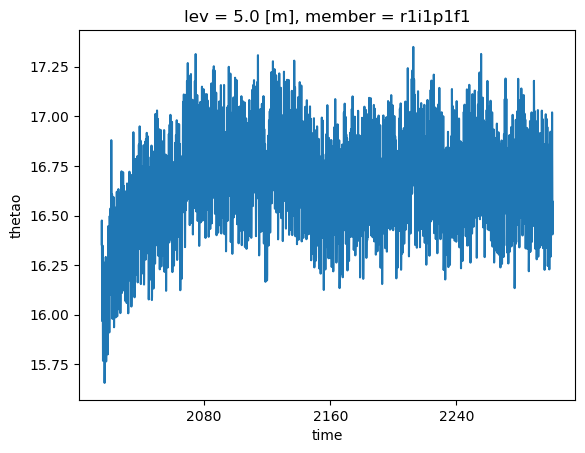

In [17]:
data.mean(dim=['i','j']).thetao.plot()

### piControl

In [22]:
search = cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']['CLEX_catalog'])

In [23]:
%%time
ds_ESM15 = load_ACCESS_ESM(search,use_cftime=True,chunking_key='ACCESS_ESM15_3D')

Loading the dataset using the chunking settings for 'ACCESS_ESM15_3D' from the configuration file: {'chunks': {'member': 1, 'time': 12, 'lev': -1, 'i': -1, 'j': -1}}
Loading the dataset with cftime = True
CPU times: user 21.3 s, sys: 2.99 s, total: 24.3 s
Wall time: 38.2 s


In [24]:
ds_ESM15

<xarray.Dataset> Size: 259GB
Dimensions:             (time: 12000, lev: 50, j: 300, i: 360, bnds: 2,
                         vertices: 4)
Coordinates:
  * time                (time) object 96kB 0101-01-16 12:00:00 ... 1100-12-16...
    time_bnds           (time, bnds) object 192kB dask.array<chunksize=(12, 2), meta=np.ndarray>
  * lev                 (lev) float64 400B 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
    lev_bnds            (lev, bnds) float64 800B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    latitude            (j, i) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude           (j, i) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    thetao              (time, lev, j, i) float32 259GB dask.array<chunksize=(12, 50, 300, 360), meta=np.ndarray>
Attributes: (12/54)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36524.0
    data_specs_version:               01.00.30
    ...                               ...
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:variable_id:     thetao
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20210316
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP6.CMIP.CSIRO.ACCESS-ESM1-5.piContro...